#### Датасет:
https://drive.google.com/drive/folders/0BxlA8wH3PTUfV1F1UTBwVTJPd3c    
#### Задания:
1. Успешно запустить имеющийся ноутбук
2. Запустить этот же ноутбук на данных ___ttk___
3. Вместо BoW попробовать tf-idf, сравнить результаты
4. Попробовать предобученные эмбеддинги для слов:
    - скачать модель fasttext http://vectors.nlpl.eu/repository/11/181.zip
    - установить пакет gensim для использования предобученной модели
    - загрузить модель и сгенерировать эмбеддинги для каждого слова в твите + затем усреднить вектора https://github.com/RaRe-Technologies/gensim-data/issues/27
    - визуализировать результат
5. Вместо TSNE можно пробовать использовать другие методы уменьшения размерности данных: PCA, Umap, Random Projection.
6. Полученные визуализации показать преподавателю    

Если будут вопросы - обращайтесь :)

# 1. Успешно запустить имеющийся ноутбук

### I. Импортим нужные библиотеки

In [4]:
import xmltodict
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from gensim.models import KeyedVectors
from sklearn.random_projection import GaussianRandomProjection
import umap


SEED=42

### II. Определяем функции с парсингом входных данных

In [2]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename, answer_func=None):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = answer_func(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

### III. Обрабатываем наши данные

In [54]:
train_filename = "data/bank_train_2016.xml"
test_filename = "data/banks_test_etalon.xml"

train = get_data(train_filename, get_sample_answers_bank)
test = get_data(test_filename, get_sample_answers_bank)

### IV. Заменяем все ссылки и юзернеймы на url и user соответственно

In [55]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [56]:
train.head()

text  answer     company  \
0                 url Взять кредит тюмень альфа банк       0    alfabank   
1                Мнение о кредитной карте втб 24 url       0         vtb   
2  «Райффайзенбанк»: Снижение ключевой ставки ЦБ ...       0  raiffeisen   
3  Современное состояние кредитного поведения в р...       0    sberbank   
4         user user Главное чтоб банки СБЕР и ВТБ!!!       1    sberbank   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [57]:
train['answer'].value_counts()

 0    7158
-1    2807
 1     760
Name: answer, dtype: int64

In [58]:
test.head()

text  answer company  \
0           #Автокредит в россельхозбанк в череповце       0    rshb   
1  RT user url #Кредитный калькулятор россельхозб...       0    rshb   
2              #Автокредит в россельхозбанк 2012 url       0    rshb   
3        RT user #Кредитные карты россельхозбанк url       0    rshb   
4      RT user #Кредиты в россельхозбанке ижевск url       0    rshb   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

### V. BoW векторайзер с 100 самыми частотными словами

In [126]:
count_vec = CountVectorizer(max_features=100)

In [60]:
X = count_vec.fit_transform(train['text'])

In [61]:
X.shape

(10725, 100)

### VI. Смотрим на результаты

In [132]:
TSNE_dec = TSNE(n_components=2, random_state=SEED)

In [17]:
%%time
X_embedded = TNSE_dec.fit_transform(X.toarray())

Wall time: 2min 9s


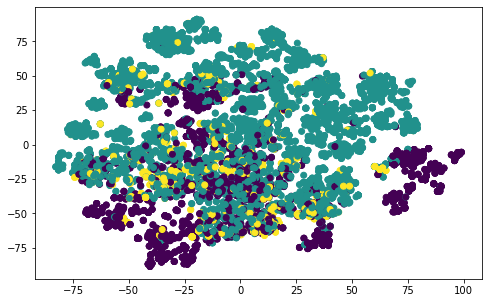

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

---

# 2 Запустить этот же ноутбук на данных ttk

### 1. get data

In [127]:
train_filename = "data/tkk_train_2016.xml"

train = get_data(train_filename, get_sample_answers_tkk)

### 2. data preprocessing

In [128]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

In [64]:
train.head(1)

text  answer  company  \
0  user Максим, Вашем письмо мы получили. Наши со...       0  beeline   

   sample_id  
0          1

In [36]:
train.text[0]

'user Максим, Вашем письмо мы получили. Наши сотрудники свяжутся с Вами завтра и направят запрос инженерам для проверки. #билайн'

### 3. BoW

In [129]:
X_tkk_count = count_vec.fit_transform(train.text)
X_tkk_count.shape

(9209, 100)

### 4. figure

In [38]:
%%time
X_embedded_tkk = TNSE_dec.fit_transform(X_tkk.toarray())

Wall time: 1min 58s


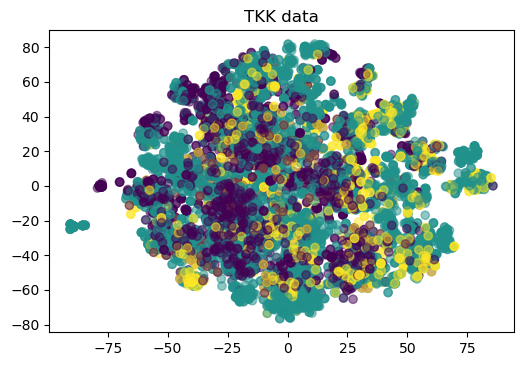

In [50]:
plt.figure(dpi=100)
plt.scatter(*X_embedded_tkk.T, c=train["answer"], alpha=0.5);
plt.title("TKK data");

___

# 3. Вместо BoW попробовать tf-idf, сравнить результаты

In [130]:
tfidf = TfidfVectorizer(max_features=100)
X_tkk_tf = tfidf.fit_transform(train.text)
X_tkk_tf.shape

(9209, 100)

In [55]:
%%time
X_embedded_tkk_tfidf = TNSE_dec.fit_transform(X_tkk_tf.toarray())

Wall time: 1min 45s


In [113]:
X_embedded_tkk_tfidf.shape

(9209, 2)

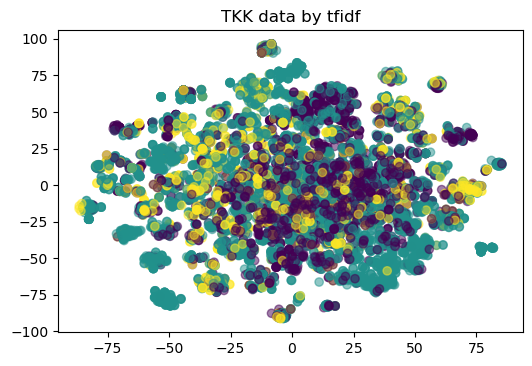

In [56]:
plt.figure(dpi=100)
plt.scatter(*X_embedded_tkk_tfidf.T, c=train["answer"], alpha=0.5);
plt.title("TKK data by tfidf");

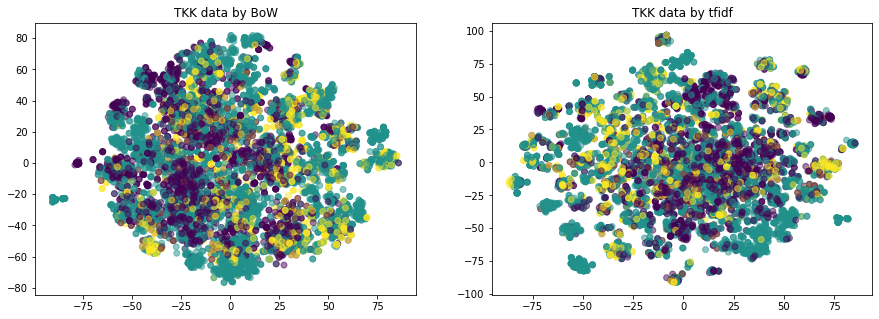

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(*X_embedded_tkk.T, c=train["answer"], alpha=0.5);
ax1.set_title("TKK data by BoW");
ax2.scatter(*X_embedded_tkk_tfidf.T, c=train["answer"], alpha=0.5);
ax2.set_title("TKK data by tfidf");

### Сравнение.
По внещниму виду кажется что в случае tdidf данные имеют меньше количество пересечений, а значит лучше разделяются.
Но лучше на таких данных обучить модель и сравнить их метрики.

# 4.  Попробовать предобученные эмбеддинги для слов:

- скачать модель fasttext http://vectors.nlpl.eu/repository/11/181.zip
- установить пакет gensim для использования предобученной модели
- загрузить модель и сгенерировать эмбеддинги для каждого слова в твите + затем усреднить вектора https://github.com/RaRe-Technologies/gensim-data/issues/27
- визуализировать результат

In [5]:
# загрузить модель
model = KeyedVectors.load('data/fasttext/model.model')

In [167]:
def get_some_strange_value(**kwargs):
    value = np.array(
        model.most_similar(
            **kwargs 
        )
    )[:, 1].astype(float).mean()  
    
    # получаем в итоге некое среднее значение по ключам,
    # Но поскольку ключи уникальные для каждого текста то такой способ мягко говоря ерунда
    # но ничего проще 3х мерных матриц я не придумал, а задание вроде как лекгое
    # так что как то так
    
    return value

In [197]:
%%time
pos = train.text.apply(lambda x: get_some_strange_value(positive=x))

Wall time: 2min 44s


In [198]:
%%time
neg = train.text.apply(lambda x: get_some_strange_value(negative=x))

Wall time: 4min 45s


In [199]:
pos.shape

(9209,)

In [157]:
def get_mean_of_text(text):
    return np.mean(
        np.array(
            [model.get_vector(word) for word in text.split()], dtype=float),
        axis=0
    )
    

In [131]:
%%time
X_tkk_fasttext = train.text.apply(lambda x: get_mean_of_text(x))

Wall time: 6.66 s


In [166]:
X_ft = np.array([np.array(i) for i in X_tkk_fasttext.values])  # непонятный костыль, обычные обертки в np.array не работают

### TSNE

In [171]:
%%time
X_tkk_fasttext_emb = TSNE_dec.fit_transform(X_ft)

Wall time: 3min 1s


### 4.4 Визуализация

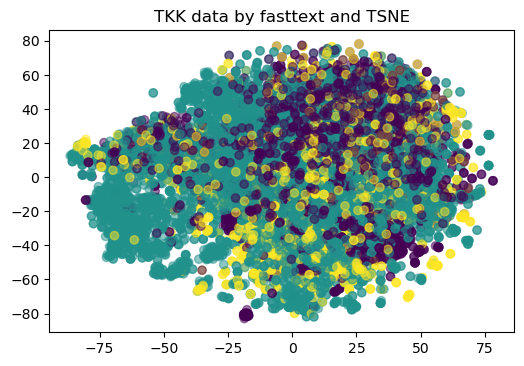

In [172]:
plt.figure(dpi=100)
plt.scatter(*X_tkk_fasttext_emb.T, c=train["answer"], alpha=0.5);
plt.title("TKK data by fasttext and TSNE");

# 5. Вместо TSNE можно пробовать использовать другие методы уменьшения размерности данных: PCA, Umap, Random Projection.

In [133]:
SVD_dec = TruncatedSVD(n_components=2, random_state=SEED)
UMAP_dec = umap.UMAP(n_components=2, random_state=SEED)
RP_dec = GaussianRandomProjection(n_components=2, random_state=SEED)

In [174]:
names = ("TSNE",
         "SVD",  # TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.
         "UMAP",
         "Random projection"
        )

methods = (TSNE_dec,
           SVD_dec,
           UMAP_dec,
           RP_dec
          )

prep_name = ["BoW", "TF-IDF", "fasttext"]

In [173]:
%%time

datas=list()
i = 0  # test value
for name, method in zip(names, methods):
    print(f"start calc of {name} |", end="")
    
    data_fasttext = method.fit_transform(X_ft)
    data_count = method.fit_transform(X_tkk_count)
    data_tfidf = method.fit_transform(X_tkk_tf)
    
    datas.append((data_count, data_tfidf, data_fasttext))
    i += 1  
    print(f" end calc of {name}")
    

start calc of TSNE | end calc of TSNE
start calc of SVD | end calc of SVD
start calc of UMAP | end calc of UMAP
start calc of Random projection | end calc of Random projection
Wall time: 10min 18s


In [185]:
plt.style.use('classic')

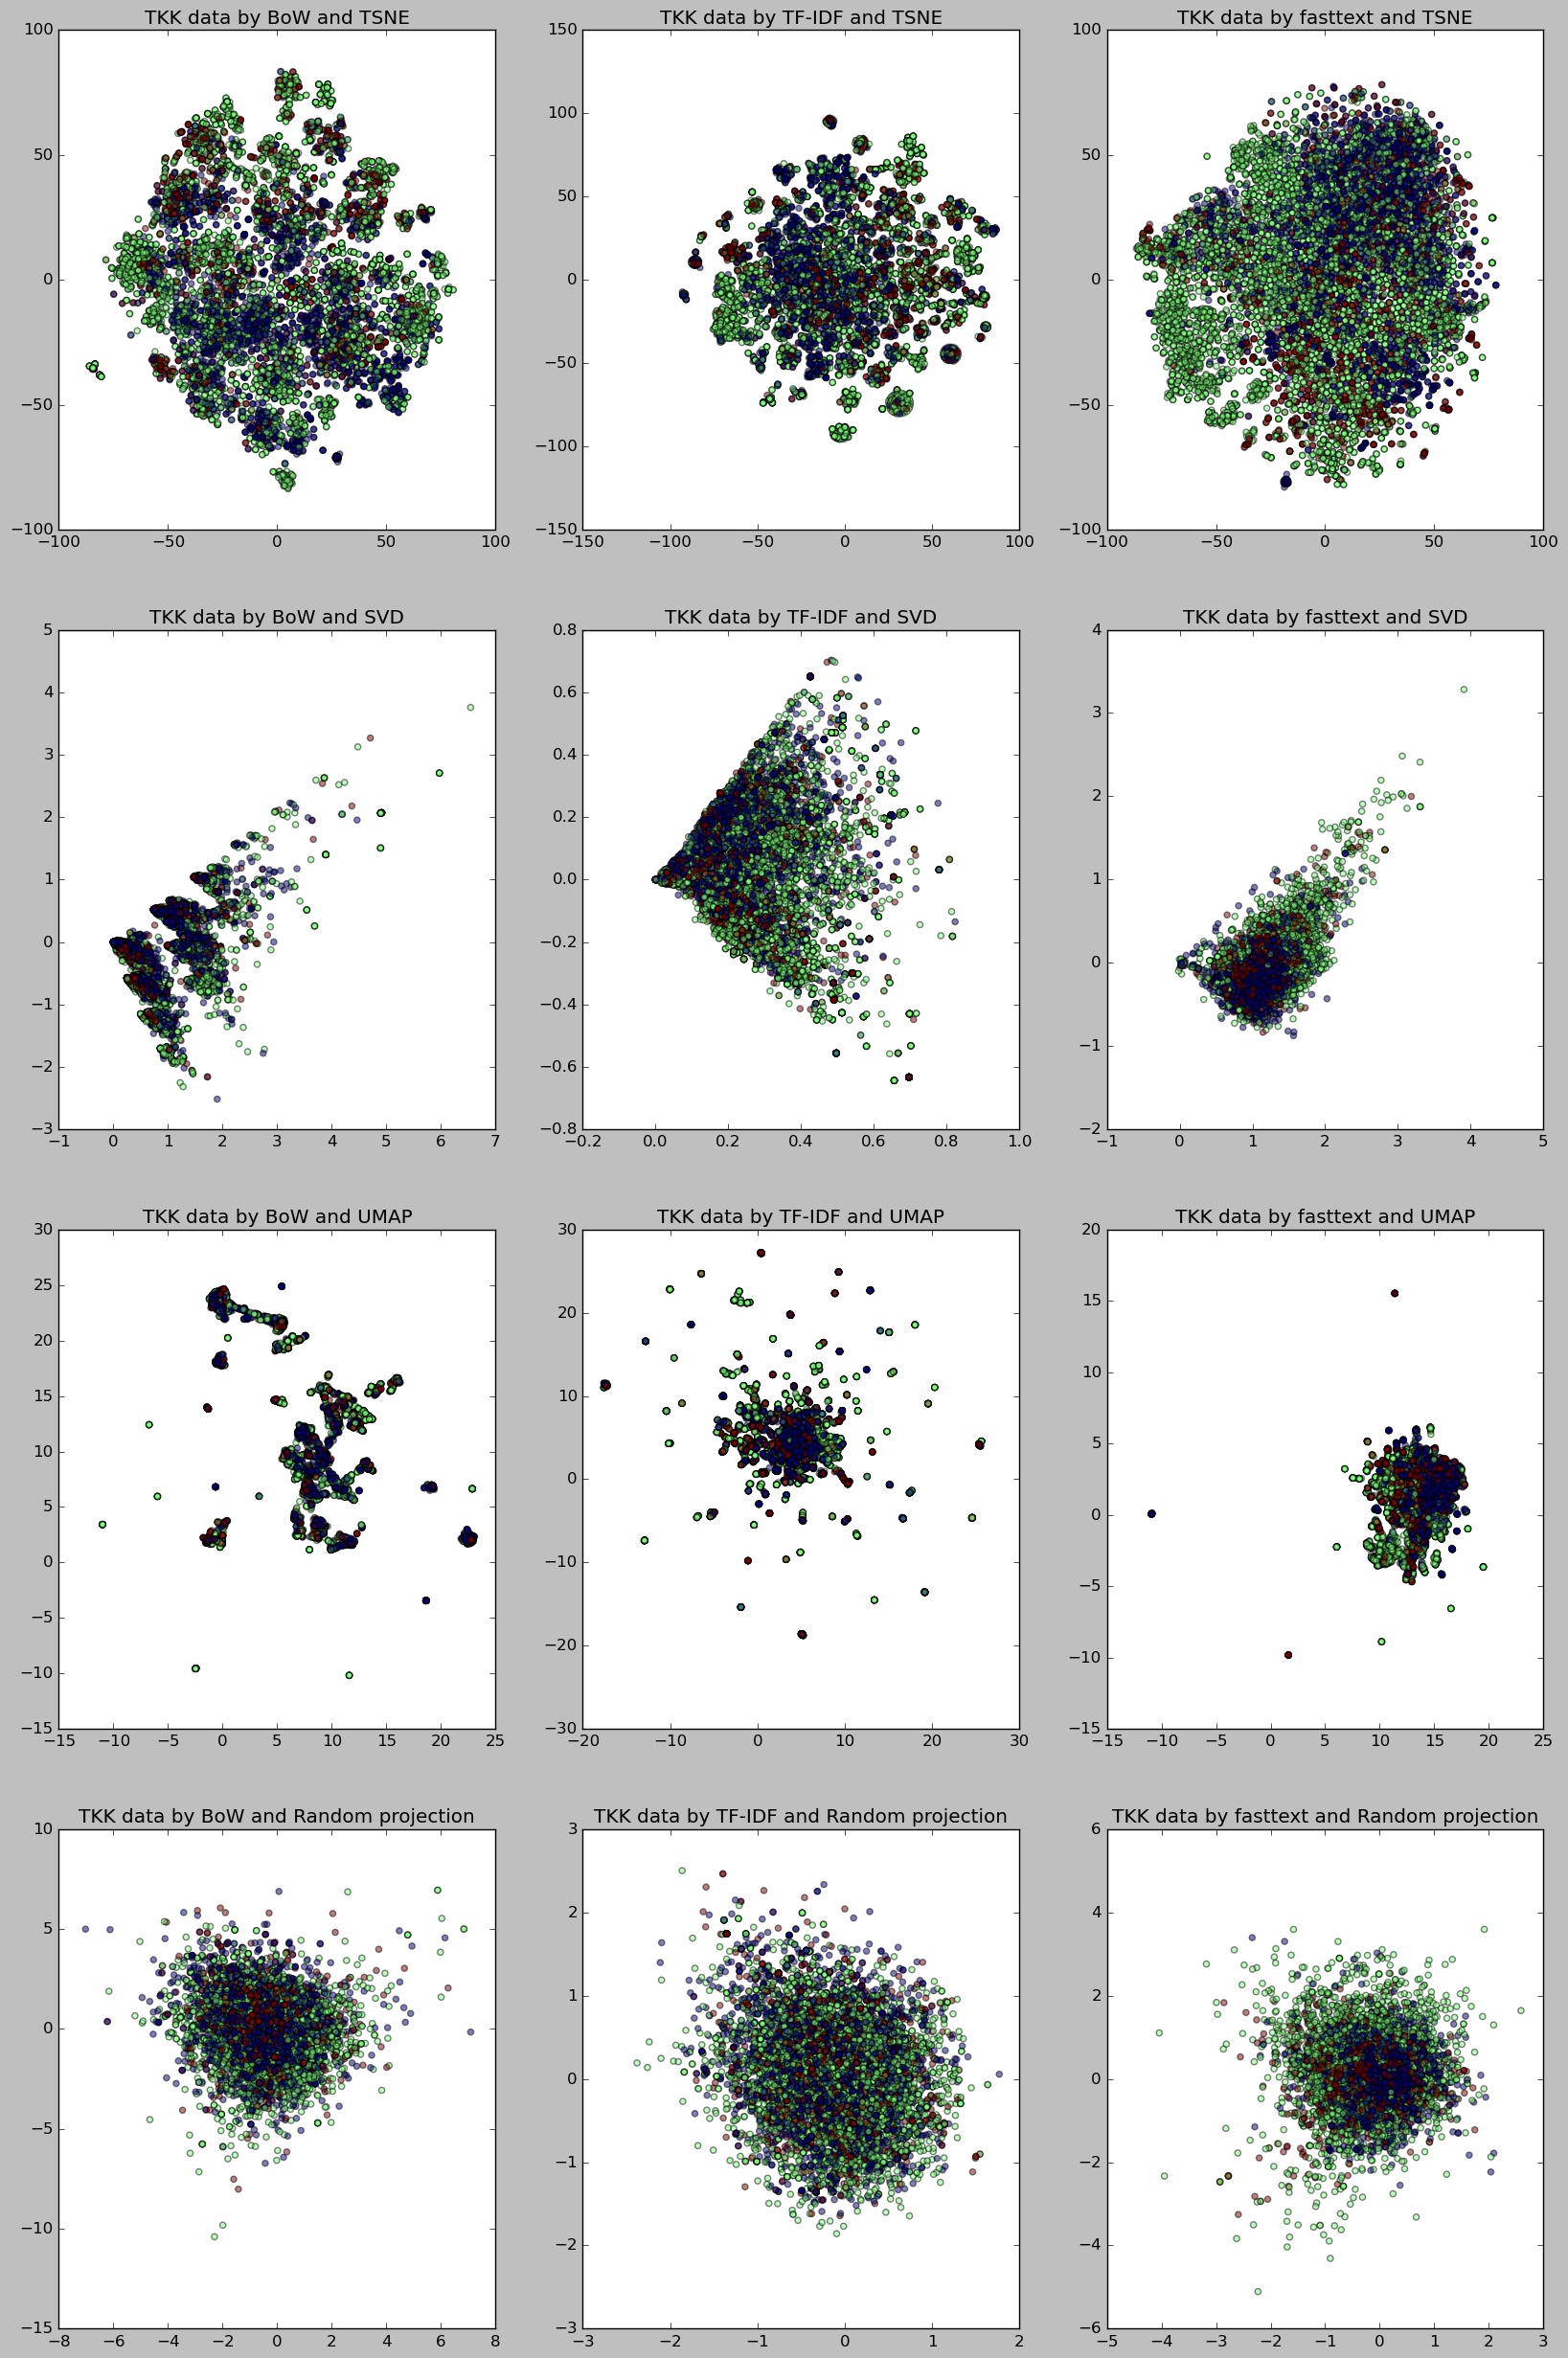

In [186]:
fig, axes = plt.subplots(4, 3, figsize=(20, 30), dpi=100)

for name, data, axe in zip(names, datas, axes):
    for l_name, ax, X in zip(prep_name, axe, data):
        ax.scatter(*X.T, c=train["answer"], alpha=0.5)
        ax.set_title(f"TKK data by {l_name} and {name}")

fig.savefig("data/Final_pic.png", dpi=100)